# Premier league: How has VAR impacted the rankings?
\[_In case of broken visualizations, view notebook here in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/notebooks/var-impact-in-premier-league/main.ipynb)._]


There has been much debate about the video assistant referee (VAR) when it was introduced last year (in 2019).
The goal is to lead to fairer refereeing, but concerns are high on whether this will really be the case and the fact that it could break the rythm of the game.

We will let football analysts – or soccer analysts depending on where you are reading this notebook from – answer this question. But one thing we can look at is how has VAR impacted the league so far.

This is what we will do in this notebook, alongside some other simulations we found interesting.

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=premier-league" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti" /></a></div>

## Importing the data

The data we will use is composed of events. An event can be anything that happens in a game: kick-off, goal, foul, etc.  
In this dataset, we only kept kick-off and goal events to build our analysis.  
Note that in the goal events we also have all the goals that were later cancelled by VAR during a game.

We will first start by importing atoti and creating a session.

In [1]:
import atoti as tt

session = tt.create_session()

Then load the events in a store

In [2]:
events = session.read_csv(
    "s3://data.atoti.io/notebooks/premier-league/events.csv",
    separator=";",
    table_name="events",
)
events.head()

,EventId,Team,Opponent,IsPlayingHome,League,Day,Half,Minute,EventType,Scorer,IsCancelledAfterVAR,IsPenalty,IsOwnGoal
0,1,Liverpool,Norwich,True,Premier League 2019/2020,1,1,42,Goal,Origi,False,False,False
1,2,Liverpool,Norwich,True,Premier League 2019/2020,1,1,28,Goal,van Dijk,False,False,False
2,3,Liverpool,Norwich,True,Premier League 2019/2020,1,1,19,Goal,Mohamed Salah,False,False,False
3,4,Norwich,Liverpool,False,Premier League 2019/2020,1,1,7,Goal,Hanley,False,False,True
4,5,Norwich,Liverpool,False,Premier League 2019/2020,1,2,64,Goal,Pukki,False,False,False


### Creating a cube

We create a cube on the event store so that some matches or teams that ended with no goal will still be reflected in the pivot tables.  

When creating a cube in the default auto mode, a hierarchy will be created for each non float column, and average and sum measures for each float column.  This setup can later be edited, or you could also define all hierarchies/measures by yourself switching to manual mode.

In [3]:
cube = session.create_cube(events)

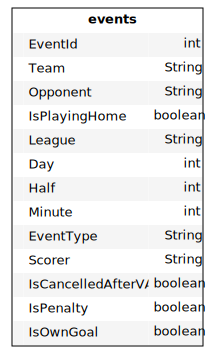

In [4]:
cube.schema

Let's assign measures/levels/hierarchies to shorter variables

In [5]:
m, l, h = cube.measures, cube.levels, cube.hierarchies

In [6]:
h["Day"] = [events["Day"]]

## Computing the rankings from the goals

Computing the first measure below to count the total goals scored for each event. At this point the total still includes the potential own goals and VAR-refused goals.

In [7]:
m["Team Goals (incl Own Goals)"] = tt.agg.sum(
    tt.where(l["EventType"] == "Goal", tt.agg.count_distinct(events["EventId"]), 0),
    scope=tt.scope.origin(l["EventType"]),
)

In this data format, own goals are scored by players from a Team, but those points should be attributed to the opponent. Therefore we will isolate the own goals in a separate measure.

In [8]:
m["Team Own Goals"] = tt.agg.sum(
    tt.where(l["IsOwnGoal"] == True, m["Team Goals (incl Own Goals)"], 0),
    scope=tt.scope.origin(l["IsOwnGoal"]),
)

And deduce the actual goals scored for the team

In [9]:
m["Team Goals"] = m["Team Goals (incl Own Goals)"] - m["Team Own Goals"]

At this point we can already have a look at the goals per team. By right clicking on the chart we have sorted it descending by team goals.

In [10]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

For a particular match, the `Opponent Goals` are equal to the `Team Goals` if we switch to the data facts where Team is replaced by Opponent and Opponent by Team

In [11]:
m["Opponent Goals"] = tt.agg.sum(
    tt.at(
        m["Team Goals"],
        {l["Team"]: l["Opponent"], l["Opponent"]: l["Team"]},
    ),
    scope=tt.scope.origin(l["Team"], l["Opponent"]),
)

In [12]:
m["Opponent Own Goals"] = tt.agg.sum(
    tt.at(
        m["Team Own Goals"],
        {l["Team"]: l["Opponent"], l["Opponent"]: l["Team"]},
    ),
    scope=tt.scope.origin(l["Team"], l["Opponent"]),
)

We are now going to add two measures `Team Score` and `Opponent Score` to compute the result of a particular match.  

In [13]:
m["Team Score"] = m["Team Goals"] + m["Opponent Own Goals"]

In [14]:
m["Opponent Score"] = m["Opponent Goals"] + m["Team Own Goals"]

We can now visualize the result of each match of the season

In [15]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We now have the team goals/score and those of the opponent for each match. However, these measures include VAR cancelled goals. Let's create new measures that takes into account VAR.

In [16]:
m["VAR team goals impact"] = m["Team Goals"] - tt.filter(
    m["Team Goals"], l["IsCancelledAfterVAR"] == False
)
m["VAR opponent goals impact"] = m["Opponent Goals"] - tt.filter(
    m["Opponent Goals"], l["IsCancelledAfterVAR"] == False
)

We can visualize that in details, there are already 4 goals cancelled by VAR on the first day of the season !

In [17]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Now that for any game we have the number of goals of each team, we can compute how many points teams have earned.  
Following the FIFA World Cup points system, three points are awarded for a win, one for a draw and none for a loss (before, winners received two points).  
We create a measure for each of this condition.

In [18]:
m["Points for victory"] = 3
m["Points for tie"] = 1
m["Points for loss"] = 0

In [19]:
m["Points"] = tt.agg.sum(
    tt.where(
        m["Team Score"] > m["Opponent Score"],
        m["Points for victory"],
        tt.where(
            m["Team Score"] == m["Opponent Score"],
            m["Points for tie"],
            m["Points for loss"],
        ),
    ),
    scope=tt.scope.origin(l["League"], l["Day"], l["Team"]),
)

The previous points were computed including VAR-refused goals.  
Filtering out these goals gives the actual rankings of the teams, as you would find on any sports websites.

In [20]:
m["Actual Points"] = tt.filter(m["Points"], l["IsCancelledAfterVAR"] == False)

And here we have our ranking. We will dive into it in the next section. 

## Rankings and VAR impact

Color rules were added to show teams that benefited from the VAR in green and those who lost championship points because of it in red.

In [21]:
m["Difference in points"] = m["Actual Points"] - m["Points"]

In [22]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

More than half of the teams have had their points total impacted by VAR.
Though it does not impact the top teams, it definitely has an impact in the ranking of many teams, Manchester United would have lost 2 ranks and Tottenham 4 for example!

We could also visualize the difference of points in a more graphical way:

In [23]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Since the rankings are computed from the goal level, we can perform any kind of simulation we want using simple UI filters.  
You can filter the pivot table above to see what would happen if we only keep the first half of the games? If we only keep matches played home? What if we filter out Vardy, would Leicester lose some places?  
Note that if you filter out VAR-refused goals, the `Points` measures takes the same value as the `Actual Points`.

## Evolution of the rankings over time

Atoti also enables you to define cumulative sums over a hierarchy, we will use that to see how the team rankings evolved during the season.  

In [24]:
m["Points cumulative sum"] = tt.agg.sum(
    m["Actual Points"], scope=tt.scope.cumulative(l["Day"])
)

In [25]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can notice that data is missing for the 28th match of Manchester City. This is because the game was delayed due to weather, and then never played because of the COVID-19 pandemic.

## Players most impacted by the VAR

Until now we looked at most results at team level, but since the data exists at goal level, we could have a look at which players are most impacted by the VAR.

In [26]:
m["Valid player goals"] = tt.filter(m["Team Goals"], l["IsCancelledAfterVAR"] == False)

In [27]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Unsurprisingly Mané is the most impacted player. He is also one of the top scorers with only Vardy scoring more goals (you can sort on the Team Goals column to verify).  
More surprisingly, Boly has had all the goals of his season cancelled by VAR and Antonio half of them..

## Simulation of a different scoring system

Although we are all used to a scoring system giving 3 points for a victory, 1 for a tie and 0 per lost match this was not always the case. Before the 1990's many european leagues only gave 2 points per victory, reason for the change being to encourage teams to score more goals during the games.
The premier league gifts us well with plenty of goals scored (take it from someone watching the French ligue 1), but how different would the results be with the old scoring system?

atoti enables us to simulate this very easily. We simply have to create a new scenario where we replace the number of points given for a victory.
We first setup a simulation on that measure.

In [28]:
scoring_system_simulation = cube.create_parameter_simulation(
    name="Scoring system simulations",
    measures={"Points for victory": 3.0},
    base_scenario_name="Current System",
)

And create a new scenario where we give it another value

In [29]:
scoring_system_simulation += ("Old system", 2.0)

And that's it, no need to define anything else, all the measures will be re-computed on demand with the new value in the new scenario.  
Let's compare the rankings between the two scoring systems.

In [30]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [31]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Surprisingly, having only 2 points for a win would only have made Burnley and West Ham lose 2 ranks, but no other real impact on the standings.

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=premier-league" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti" /></a></div>